In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np

# Bonus vector manipulation
import pandas as pd
#from pandas import Dataframe
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import xarray as xr

import dask

In [2]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

# **Water Permamency**


Import required DC utils

In [3]:
import datacube
# DC utilities
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.import_export import export_xarray_to_netcdf
from datacube_utilities.createAOI import create_lat_lon
from datacube.storage import masking
from datacube_utilities.clean_mask import lee_filter
from datacube_utilities.dc_utilities import write_geotiff_from_xr


Define aoi via wkt polygon (could be subbed or shapefile)

In [4]:
#aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
#testarea
#aoi_wkt = "POLYGON((177.75226467901712 -17.879622210337537,177.80204647833352 -17.879622210337537,177.80204647833352 -17.914988456071715,177.75226467901712 -17.914988456071715,177.75226467901712 -17.879622210337537))"
#aoi_wkt = "POLYGON((177.75226467901712 -17.879622210337537,177.80204647833352 -17.879622210337537,177.80204647833352 -17.914988456071715,177.75226467901712 -17.914988456071715,177.75226467901712 -17.879622210337537))"
aoi_wkt = "POLYGON((177.34673877691375 -17.587272740290974,177.6955546948825 -17.587272740290974,177.6955546948825 -17.800529711996226,177.34673877691375 -17.800529711996226,177.34673877691375 -17.587272740290974))"
#whole country
#aoi_wkt = "POLYGON((177.34096527101 -17.746353149414, 177.43160247804 -17.744293212891, 177.4364089966 -17.834930419922, 177.34165191652 -17.833557128906, 177.34096527101 -17.746353149414))"
#lake
aoi_wkt = "POLYGON((177.59915340432389 -17.691752026788183,177.72892940530045 -17.691752026788183,177.72892940530045 -17.786908616177815,177.59915340432389 -17.786908616177815,177.59915340432389 -17.691752026788183))"
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')

In [24]:
#set baseline start and end of period
start_date = '2000-1-1'
end_date = '2003-12-30'
res = (30)

output_projection = "EPSG:3460"
crs = "EPSG:3460"

In [25]:
dc = datacube.Datacube(app="water permamency")

In [26]:
dask_chunks=dict(
    x=1000,
    y=1000
)

In [27]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [28]:
display_map(latitude = lat_extents, longitude = lon_extents)

In [29]:
from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")

In [30]:
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)

In [31]:
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)

In [32]:
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)

In [33]:
#create resolution
resolution = (-res, res)

In [34]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(start_date, end_date)

### Load Data

Generic query specs

In [35]:
query = dict(latitude = lat_range,
             longitude = lon_range,
             output_crs = output_projection,
             crs = crs,
             time = baseline_time_period,
             resolution = resolution,
             group_by = 'solar_day',
             dask_chunks = dask_chunks,   
            )


Dataset-specifics

In [36]:
dsL8 = dc.load(product='ls7_water_classification',
               measurements = ["water"],
               **query)

In [37]:

def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [38]:
waterL8 = dsL8.where(dsL8 != -9999)

In [39]:
waterL8_comp = waterL8.compute()

In [40]:
water_composite_mean = waterL8_comp.water.mean(dim='time')

Visualise wofs summary product

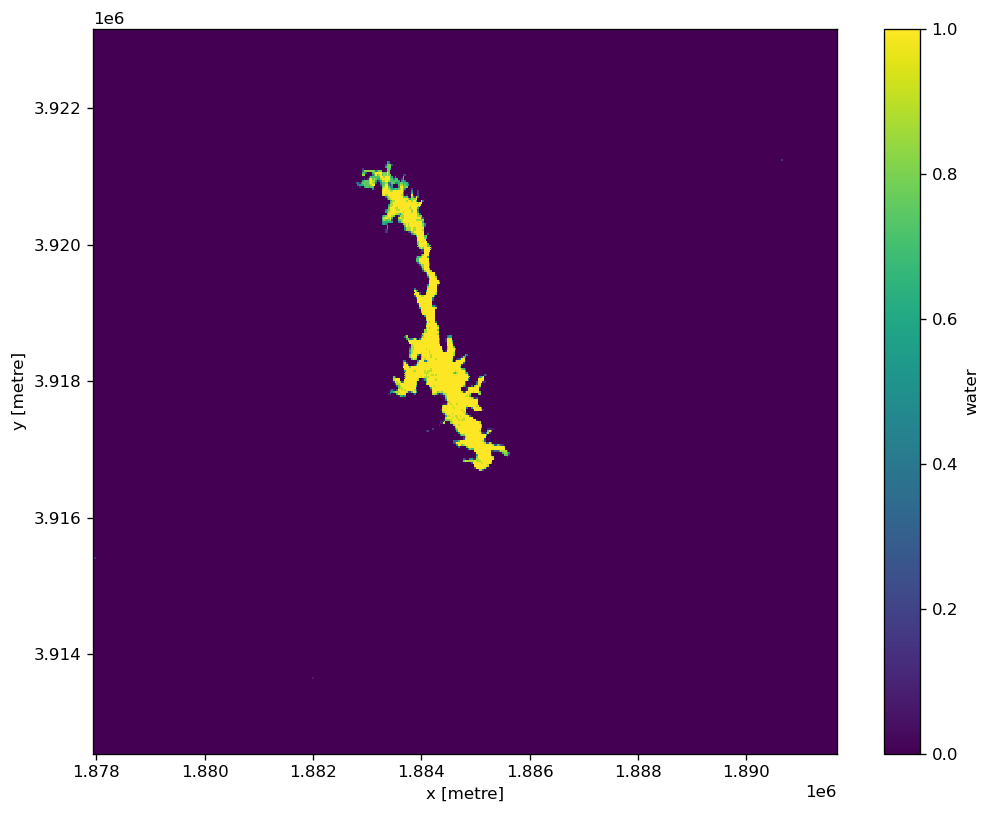

In [41]:
plt.figure(figsize = (10,8), dpi=120)
waterL8_comp.water.mean(dim='time').plot();

In [23]:
#ndvi_anomaly_export = xr.DataArray.to_dataset(merged, dim = None, name = 'ls8')
write_geotiff_from_xr('ls8_water.tiff', water_composite_mean, ["water"], crs=output_projection, x_coord = 'x', y_coord = 'y')